In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def lambdan(n,peak):
    beta=(20 + (8*np.sin(2*np.pi*(960+n)/1440)))*peak/29
    b=np.ceil(beta)
    return np.random.randint(low=b-10,high=b+10+1)



* E̶s̶c̶o̶l̶h̶e̶r̶ ̶a̶d̶i̶c̶i̶o̶n̶a̶r̶ ̶o̶u̶ ̶n̶a̶o̶ ̶u̶m̶ ̶u̶s̶u̶á̶r̶i̶o̶ ̶t̶a̶l̶v̶e̶z̶ ̶s̶e̶g̶u̶i̶n̶d̶o̶ ̶u̶m̶a̶ ̶s̶e̶n̶o̶i̶d̶e̶ ̶(̶d̶e̶ ̶q̶u̶a̶n̶t̶o̶ ̶e̶m̶ ̶q̶u̶a̶n̶t̶o̶ ̶t̶e̶m̶p̶o̶?̶ ̶t̶e̶s̶t̶a̶r̶ ̶a̶ ̶c̶a̶d̶a̶ ̶m̶i̶n̶u̶t̶o̶)̶
* A cada usuário alocar apenas um arquivo
* A cada minuto o sistema verá o estado (quanta capacidade é necessária)
* Aumentar os estados para incluir os de "bloqueio"

In [ ]:
#def FTP(users):
#    mu = [32.542, 3, 4]
#    s = [1, 1, 2.54]
#    total_data = 2**np.random.normal(mu[0],s[0],users)
#    data_perfile = 2**np.random.normal(mu[1],s[1],users)
#    interval = 10**np.random.normal(mu[2],s[2],users)
#    return total_data,data_perfile,interval

In [5]:
def def_state(maxu=250,U=25,maxre=9):
    states = []
    for ii in range(int(maxu/U)+1):
        for jj in range(maxre):
            states.append((ii+1) + 1j*(jj+1))
    return states

In [6]:
def pick_state(states,u,re,maxre=9,maxu=250,U=25,UpR=50):
        if u>maxre*UpR:
            return states.index((maxu/U+1)+1j*re)
        else:
            return states.index(np.ceil(u/U)+1j*re)

In [7]:
def def_QT(states,actions,U=25,UpR=50):
    Q = np.zeros([len(states),actions])
    for ii in range(len(states)):
        for jj in range(actions):
            if np.real(states[ii])*U > (np.imag(states[ii])+(1-np.imag(states[ii])+jj))*UpR:
                Q[ii,jj] = -1000
    return Q

In [62]:
def epsilon_greedy(Q,states,State0,re,epsilon,maxre):
    if np.real(states[State0])*25 > maxre*50:
        a = maxre-1
    else:
        if np.random.rand()<epsilon:
            if len(np.where(Q[State0]>-1000))>0: #checks if there is at least one state that doesn't lead to block
                a=np.random.choice(np.where(Q[State0]>-1000)[0]) #prevents moving to a blocking state
            else:
                a=np.random.randint(low=0,high=maxre+1)
        else: 
            a=Q[state0].argmax()
    return a

In [9]:
def reward(u,re,a,maxre,UpR=50,P=-1000):
    if u>(re+(1-re+a))*UpR:
        R = P
    else:
        R = maxre -(re+(1-re+a))
    return R

In [ ]:
def teste_qtable(Q,vtU,alpha=0.5,gamma=0.3,M=30,U=50,N=25,P=-1000):
    EnS=0
    pblock=0
    m0=6
    u0=vtU[0]
    for u in vtU:
        state0=pick_state(u=u0,m=m0,N=N,U=U)
        a=Q[state0].argmax()-m0
        m1=m0+a
        u0=u
        state1=pick_state(u=u0,m=m1,N=N,U=U)
        r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
        if r==P:
            pblock=pblock+1
        Q[state0][a+m0]=(1-alpha)*Q[state0][a+m0] + alpha*(r + gamma*(Q[state1].max()))
        m0=m1
        EnS=EnS+(M-m0)
    return pblock,EnS

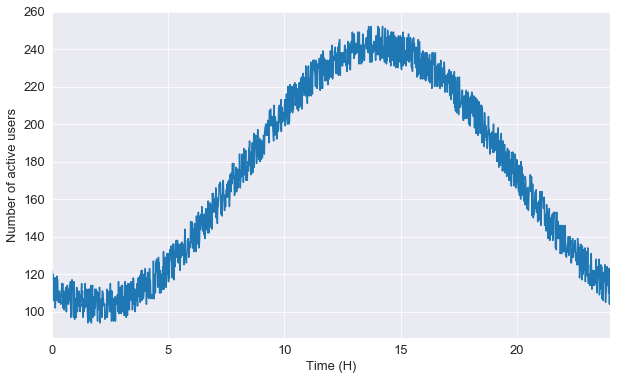

In [25]:
peak = 250
vtU=[]
for ii in range(0,60*24):
    vtU.append(lambdan(ii,peak))
seU=pd.Series(vtU)
seU.index=seU.index/(60)
seU.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()

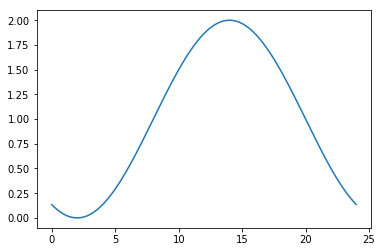

In [57]:
t = np.arange(24*60)
plt.plot(t/60,1+np.sin(2*np.pi*(960+t)/1440))
plt.show()

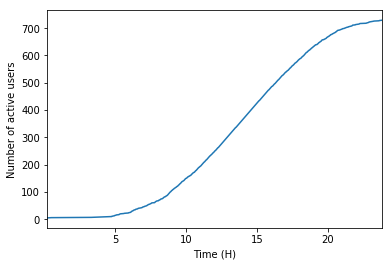

In [60]:
users = []
ii = []
user=5
for i in range(24*60):
    if np.random.uniform(low=0,high=2) <= 1+np.sin(2*np.pi*(960+i)/1440):
        users = np.append(users,user)
        ii.append(i)
        user = user+1
df = pd.Series(data = users,index=ii)
df.index = df.index/60
df.plot()
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()


In [48]:
Pcnt=100 #fixed power
Pr=30 #Power per resource
maxre=4 #max number of resources
U=50 #max number of users by each resource
N=25 #quantization of users
peak=250 #peak of traffic
P=-1000 #penalization
epsilon=0.05 #epsilon for e-greedy
gamma=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] #discount rates
alpha=[0.3, 0.5, 0.7] #learning rates
maxEps=24*60*30 #Time for simulation: 30 days
dMC=20 #number of monte carlo simulations

In [63]:
vtBlock=np.zeros([len(alpha),len(gamma)])
vtEnS=np.zeros([len(alpha),len(gamma)])
states = def_state(peak,N,maxre)
for mc in range(dMC):
    for rate in range(0,len(alpha)):
        alphan=alpha[rate]
        for discount in range(0,len(gamma)):
            gamman=gamma[discount]
            QT = def_QT(states,maxre)
            re0 = np.random.randint(low=1,high=maxre+1)
            pblock=0
            EnS=0
            u0=lambdan(0,peak)
            for epoch in range(0,maxEps):
                state0 = pick_state(states,u0,re0,maxu=peak)
                a = epsilon_greedy(QT,states,state0,re0,epsilon,maxre)
                r = reward(u0,re0,a)
                u0 = lambdan(epoch,peak)
                re1 = re0+(a+1-re0) 
                state1 = pick_state(states,u0,re1,maxu=peak)
                if r==P:
                    pblock=pblock+1
                QT[state0][a] = (1-alphan)*QT[state0][a] + alphan*(r + gamman*(QT[state1].max()))
                re0=re1
                EnS=EnS+(maxre-re0)
            vtBlock[rate][discount]=vtBlock[rate][discount]+pblock
            vtEnS[rate][discount]=vtEnS[rate][discount]+EnS

In [64]:
vtBlock=(vtBlock/maxEps)/dMC
vtEnS=((vtEnS/maxEps)*100/maxre)/dMC
sns.set_style(style='darkgrid')

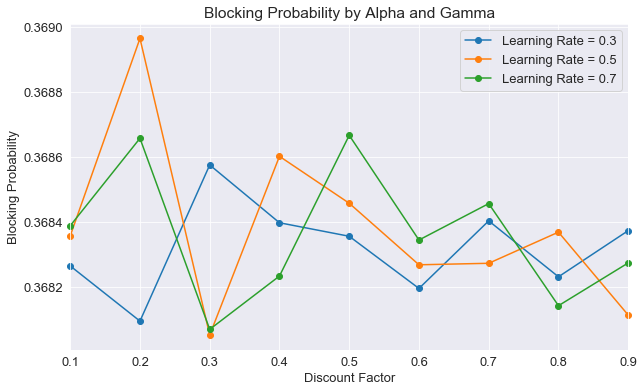

In [65]:
dfBlock=pd.DataFrame(vtBlock.T,index=gamma,columns=alpha)
dfBlock.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Blocking Probability')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Blocking Probability by Alpha and Gamma')
plt.rc('font',size=13)
plt.show()

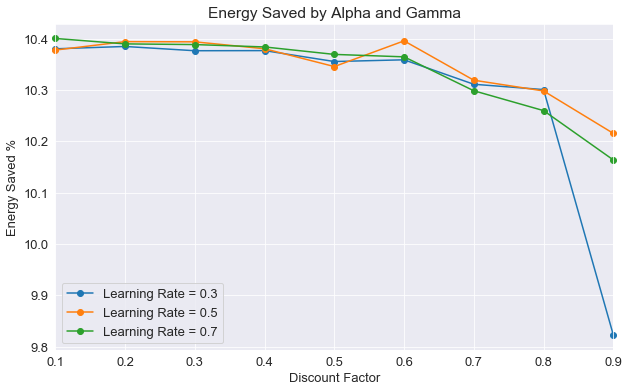

In [66]:
dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
plt.show()

In [17]:
alpha = 0.7
discount = 0.3
epsilon = 0.2

43199

In [ ]:
Q=def_QT(length=lenStateSpace,M=M,U=U,N=N,P=P)
re=np.random.randint(low=1,high=maxre)
vtBlock=[]
vtEnS=[]
contador=0
u0=lambdan(0,peak)
for epoch in range(0,24*60*30):
    contador=contador+1
    state0=pick_state(u=u0,m=m0,N=N,U=U)
    a=epsilon_greedy(Q,state0,m0,epsilon,M)
    m1=m0+a
    u0=lambdan(epoch,peak)
    state1=pick_state(u=u0,m=m1,N=N,U=U)
    r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
    Q[state0][a+m0]=(1-alpha)*Q[state0][a+m0] + alpha*(r + gamma*(Q[state1].max()))
    m0=m1
    ######teste#####
    if contador==24*60:
        pblock,EnS=teste_qtable(Q=Q,vtU=vtU,alpha=0.5,gamma=0.3,M=30,U=50,N=25,P=-1000)
        vtBlock.append(pblock/(60*24))
        vtEnS.append(EnS/(60*24)*100/M)
        contador=0

In [60]:
a

4